In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal
from operator import itemgetter
import multiprocessing
from CustomFunctions import PCvisualization

def cllct_rslts(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.extend(result)
def collect_results(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.append(result)


#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [9]:
#get directories and open separated datasets

time_interval = 5 #sec/frame

datadir = 'E:/Aaron/random_lls/'
savedir = datadir + 'random/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

TotalFrame = pd.read_csv(datadir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)

centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)

nbins = np.max(TotalFrame[[x for x in TotalFrame.columns.to_list() if 'bin' in x]].to_numpy())

#restrict dataframe to only random experiments
TotalFrame = TotalFrame[TotalFrame.Treatment=='Random']

In [11]:
########### ALL PC CGPS's ##############

from CustomFunctions.DetailedBalance import get_transition_counts, interpolate_2dtrajectory
import itertools

specdir = savedir + 'All_CGPS/'
if not os.path.exists(specdir):
    os.makedirs(specdir)

binlist = [i for i in TotalFrame.columns.to_list() if 'bin' in i]
for a in binlist:
    for b in binlist:
        bin1 = a.split('bin')[0]
        bin2 = b.split('bin')[0]
        if a == b:
            continue
        
        elif (os.path.exists(specdir+f'interpolated_{bin1}-{bin2}_transitions_separated.csv')) & (os.path.exists(specdir+f'interpolated_{bin1}-{bin2}_transition_pairs_separated.csv')):
        
            transdf_sep = pd.read_csv(specdir+f'interpolated_{bin1}-{bin2}_transitions_separated.csv', index_col=0)
            transpairsdf_sep = pd.read_csv(specdir+f'interpolated_{bin1}-{bin2}_transition_pairs_separated.csv', index_col=0)
            print(f'Opened {bin1}-{bin2} transition files')
            #ensure that DMSO is the first in order
            
        elif (os.path.exists(specdir+f'interpolated_{bin2}-{bin1}_transitions_separated.csv')) & (os.path.exists(specdir+f'interpolated_{bin2}-{bin1}_transition_pairs_separated.csv')):
            print('Already made this plot')
            continue
            
        else:
            if __name__ ==  '__main__':
                results = []
                pool = multiprocessing.Pool(processes=multiprocessing.cpu_count()-1)
                for i, cells in TotalFrame.groupby('CellID'):
                    cells = cells.sort_values('time').reset_index(drop = True)
                    diff = cells.time.diff()
                    difflist = [0]
                    difflist.extend(diff[diff>5].index.to_list())
                    runs = []
                    for x in range(len(difflist)-1):
                        runs.append(list(range(difflist[x], difflist[x+1])))

                    for r in runs:
                        r = np.array(r, dtype=int)
                        #skip runs less than 3 frames long
                        if len(r)<2:
                            pass
                        else:
                            cell = cells.iloc[r]

                            pool.apply_async(interpolate_2dtrajectory, args = (
                                time_interval,
                                cell.CellID.iloc[0],
                                cell.frame.to_list(),
                                cell[[a,b]].to_numpy(),
                                ),
                                callback = collect_results)
                pool.close()
                pool.join()


            transdf_sep = pd.DataFrame(sum([r[0] for r in results],[]))
            transdf_sep = transdf_sep.sort_values(by = ['CellID','frame']).reset_index(drop=True)
            transpairsdf_sep = pd.DataFrame(sum([r[1] for r in results],[]))
#             transdf_sep['Treatment'] = [m]*len(transdf_sep)
#             transpairsdf_sep['Treatment'] = [m]*len(transpairsdf_sep)

            transdf_sep.to_csv(specdir+f'interpolated_{bin1}-{bin2}_transitions_separated.csv')
            transpairsdf_sep.to_csv(specdir+f'interpolated_{bin1}-{bin2}_transition_pairs_separated.csv')
            print(f'Finished interpolating trajectories for {bin1}-{bin2}')
            
            
        ############## get the counts of cells leaving 


        if os.path.exists(specdir+f'{bin1}-{bin2}_binned_transition_rates_separated.csv'):
            trans_rate_df_sep = pd.read_csv(specdir+f'{bin1}-{bin2}_binned_transition_rates_separated.csv', index_col=0)
            print(f'Opened {bin1}-{bin2} transition rate files')
            
        elif os.path.exists(specdir+f'{bin2}-{bin1}_binned_transition_rates_separated.csv'):
            print('Already made this plot')
            continue
            
        else:
            trresults = []
            if __name__ ==  '__main__':
                ttot = transdf_sep.time_elapsed.sum()
                print(ttot)
                pool = multiprocessing.Pool(processes=60)
                results = []
                for x in range(nbins):
                    for y in range(nbins):
                        fromm = transdf_sep[(transdf_sep['from_x'] == x+1) & (transdf_sep['from_y'] == y+1)].reset_index(drop=True).to_dict()
                        to = transdf_sep[(transdf_sep['to_x'] == x+1) & (transdf_sep['to_y'] == y+1)].reset_index(drop=True).to_dict()
                        pool.apply_async(get_transition_counts, args = (
                            x+1,
                            y+1,
                            fromm,
                            to,
                            ttot,
                            ),
                            callback = collect_results)
                pool.close()
                pool.join()

            trans_rate_df_sep = pd.DataFrame(results)
#             trans_rate_df_sep['Treatment'] = [m]*len(trans_rate_df_sep)
            trans_rate_df_sep = trans_rate_df_sep.sort_values(by = ['x','y']).reset_index(drop=True)

            trans_rate_df_sep.to_csv(specdir+f'{bin1}-{bin2}_binned_transition_rates_separated.csv')

            print(f'Finished finding transition rates for {bin1}-{bin2}')

            
            
#         ########### PDFs AND PROBABILITY FLUX OF THE SEPARATED MIGRATION MODES #############
#         from matplotlib.patches import Ellipse, Rectangle
#         from CustomFunctions.DetailedBalance import contour_coords
#         # inverse scale for arrows
#         scale = 0.0002


#         fig, ax = plt.subplots()
#         #single colorbar axis
#         cbar_ax = fig.add_axes([.98, .2, .015, .5])

#         ################ heatmap of probability density #############
#         mm = transdf_sep.Treatment.unique()[i]
#         mdf = transdf_sep[transdf_sep.Treatment==mm]
#         ttot = mdf.time_elapsed.sum()
#         #make numpy array with heatmap data
#         bighm = np.zeros((nbins,nbins))
#         #get total time observed in the system

#         for x in range(nbins):
#             for y in range(nbins):
#                 current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
#                 if current.empty:
#                     bighm[y,x] = 0
#                 else:
#                     bighm[y,x] = current.time_elapsed.sum()/ttot
#         #plot heatmap with seaborn
#         sns.heatmap(
#             bighm,
#             vmin=0, vmax=0.05, #center=0,
#             cmap='rocket',
#             square=True,
#             xticklabels = True,
#             yticklabels = True,
#             ax = ax,
#             cbar=i==0,
#             cbar_ax = None if i else cbar_ax,
#     #         cbar_kws=cbar_kws
#         )

#         ######################### vector map of probability flux ################
#         mm = trans_rate_df_sep.Treatment.unique()[i]
#         mdf = trans_rate_df_sep[trans_rate_df_sep.Treatment==mm]

#         for x in range(1,nbins+1):
#             for y in range(1,nbins+1):
#                 current = mdf[(mdf['x'] == x) & (mdf['y'] == y)]
#                 xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
#                 ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
#                 ax.quiver(x-0.5,
#                            y-0.5, 
#                            xcurrent,
#                            ycurrent,
#                           angles = 'xy',
#                           scale_units = 'xy',
#                           scale = scale,
#     #                       width = 0.012,
#     #                       minlength = 0.8,
#                           color = 'white')




#         # axis label stuff
#         ax.set_xlabel(bin1, fontsize = 45)
#         ax.set_xticks(np.arange(0.5,nbins+0.5),[round(x,1) for x in centers[bin1].to_list()])
#         ax.set_xticklabels(ax.get_xticklabels(), fontsize = 22)
#         ax.set_yticks(np.arange(0.5,nbins+0.5),[round(x,1) for x in centers[bin2].to_list()])
#         ax.set_yticklabels(ax.get_yticklabels(), fontsize = 22)
#         ax.set_xlim(0,nbins+1)
#         ax.set_ylim(0,nbins+1)
#         ax.set_title(mm, fontsize = 45)


#         # adjust colorbar tick label size
#         cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#         #set axis title
#         graphaxes[0].set_ylabel(bin2, fontsize = 45)



#         ########## add scale for the vectors ##########
#         #legend background
#         lxp = 0.125
#         lyp = 0.125
#         rect = Rectangle((lxp, lyp), 1.8, 1.8, linewidth=1, edgecolor='black', facecolor='#80858a')
#         ax.add_patch(rect)
#         rect.set_zorder(4 * 5)
#         #x-axis legend arrow
#         ax.quiver(lxp+0.5,lyp+0.5,1*scale,0,angles = 'xy',scale_units = 'xy',scale = scale,color = "white",zorder = 4 * 5)
#         #x-axis legend text
#         xsc = f'{(np.diff(centers[bin1]).mean()/time_interval)*scale:.1e}'
#         xsc = xsc.split('-')[0] + str(int(xsc.split('e')[1]))
#         ax.text(lxp+0.25,lyp+0.05,xsc+' $s^{-1}$', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)
#         #y-axis legend arrow
#         ax.quiver(lxp+0.5,lyp+0.5,0,1*scale,angles = 'xy',scale_units = 'xy',scale = scale,color = 'white',zorder = 4 * 5)
#         #y-axis legend text
#         ysc = f'{(np.diff(centers[bin2]).mean()/time_interval)*scale:.1e}'
#         ysc = ysc.split('-')[0] + str(int(ysc.split('e')[1]))
#         ax.text(lxp+0.05,lyp+0.3,ysc+' $s^{-1}$', rotation = 'vertical', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)



#         plt.tight_layout()
#         plt.savefig(specdir + f'{bin1}-{bin2} probability flux and pdf separated.png', bbox_inches='tight')
#         plt.close()
#         print(f'Saved {bin1}-{bin2} plot')

Finished interpolating trajectories for PC1-PC2
39602.97773744365
Finished finding transition rates for PC1-PC2
Finished interpolating trajectories for PC1-PC3
39752.699331068354
Finished finding transition rates for PC1-PC3
Finished interpolating trajectories for PC1-PC4
39554.87175138004
Finished finding transition rates for PC1-PC4
Finished interpolating trajectories for PC1-PC5
39518.337088436034
Finished finding transition rates for PC1-PC5
Finished interpolating trajectories for PC1-PC6
39737.82467529362
Finished finding transition rates for PC1-PC6
Finished interpolating trajectories for PC1-PC7
39682.86909193771
Finished finding transition rates for PC1-PC7
Finished interpolating trajectories for PC1-PC8
40069.79411251415
Finished finding transition rates for PC1-PC8
Finished interpolating trajectories for PC1-PC9
39968.53723502492
Finished finding transition rates for PC1-PC9
Finished interpolating trajectories for PC1-PC10
39876.14290602604
Finished finding transition rates f

remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
Opened PC9-PC10 transition rate files
remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
Opened PC8-PC10 transition rate files
Opened PC8-PC9 transition rate files
remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
Opened PC7-PC10 transition rate files
Opened PC7-PC9 transition rate files
Opened PC7-PC8 transition rate files
remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
remove this plot
Opened PC6-PC10 transition rate files
Opened PC6-PC9 transition rate files
Opened PC6-PC8 transition rate files
Opened PC6-PC7 transition rate files
remove this plot
remove this plot
remove this pl

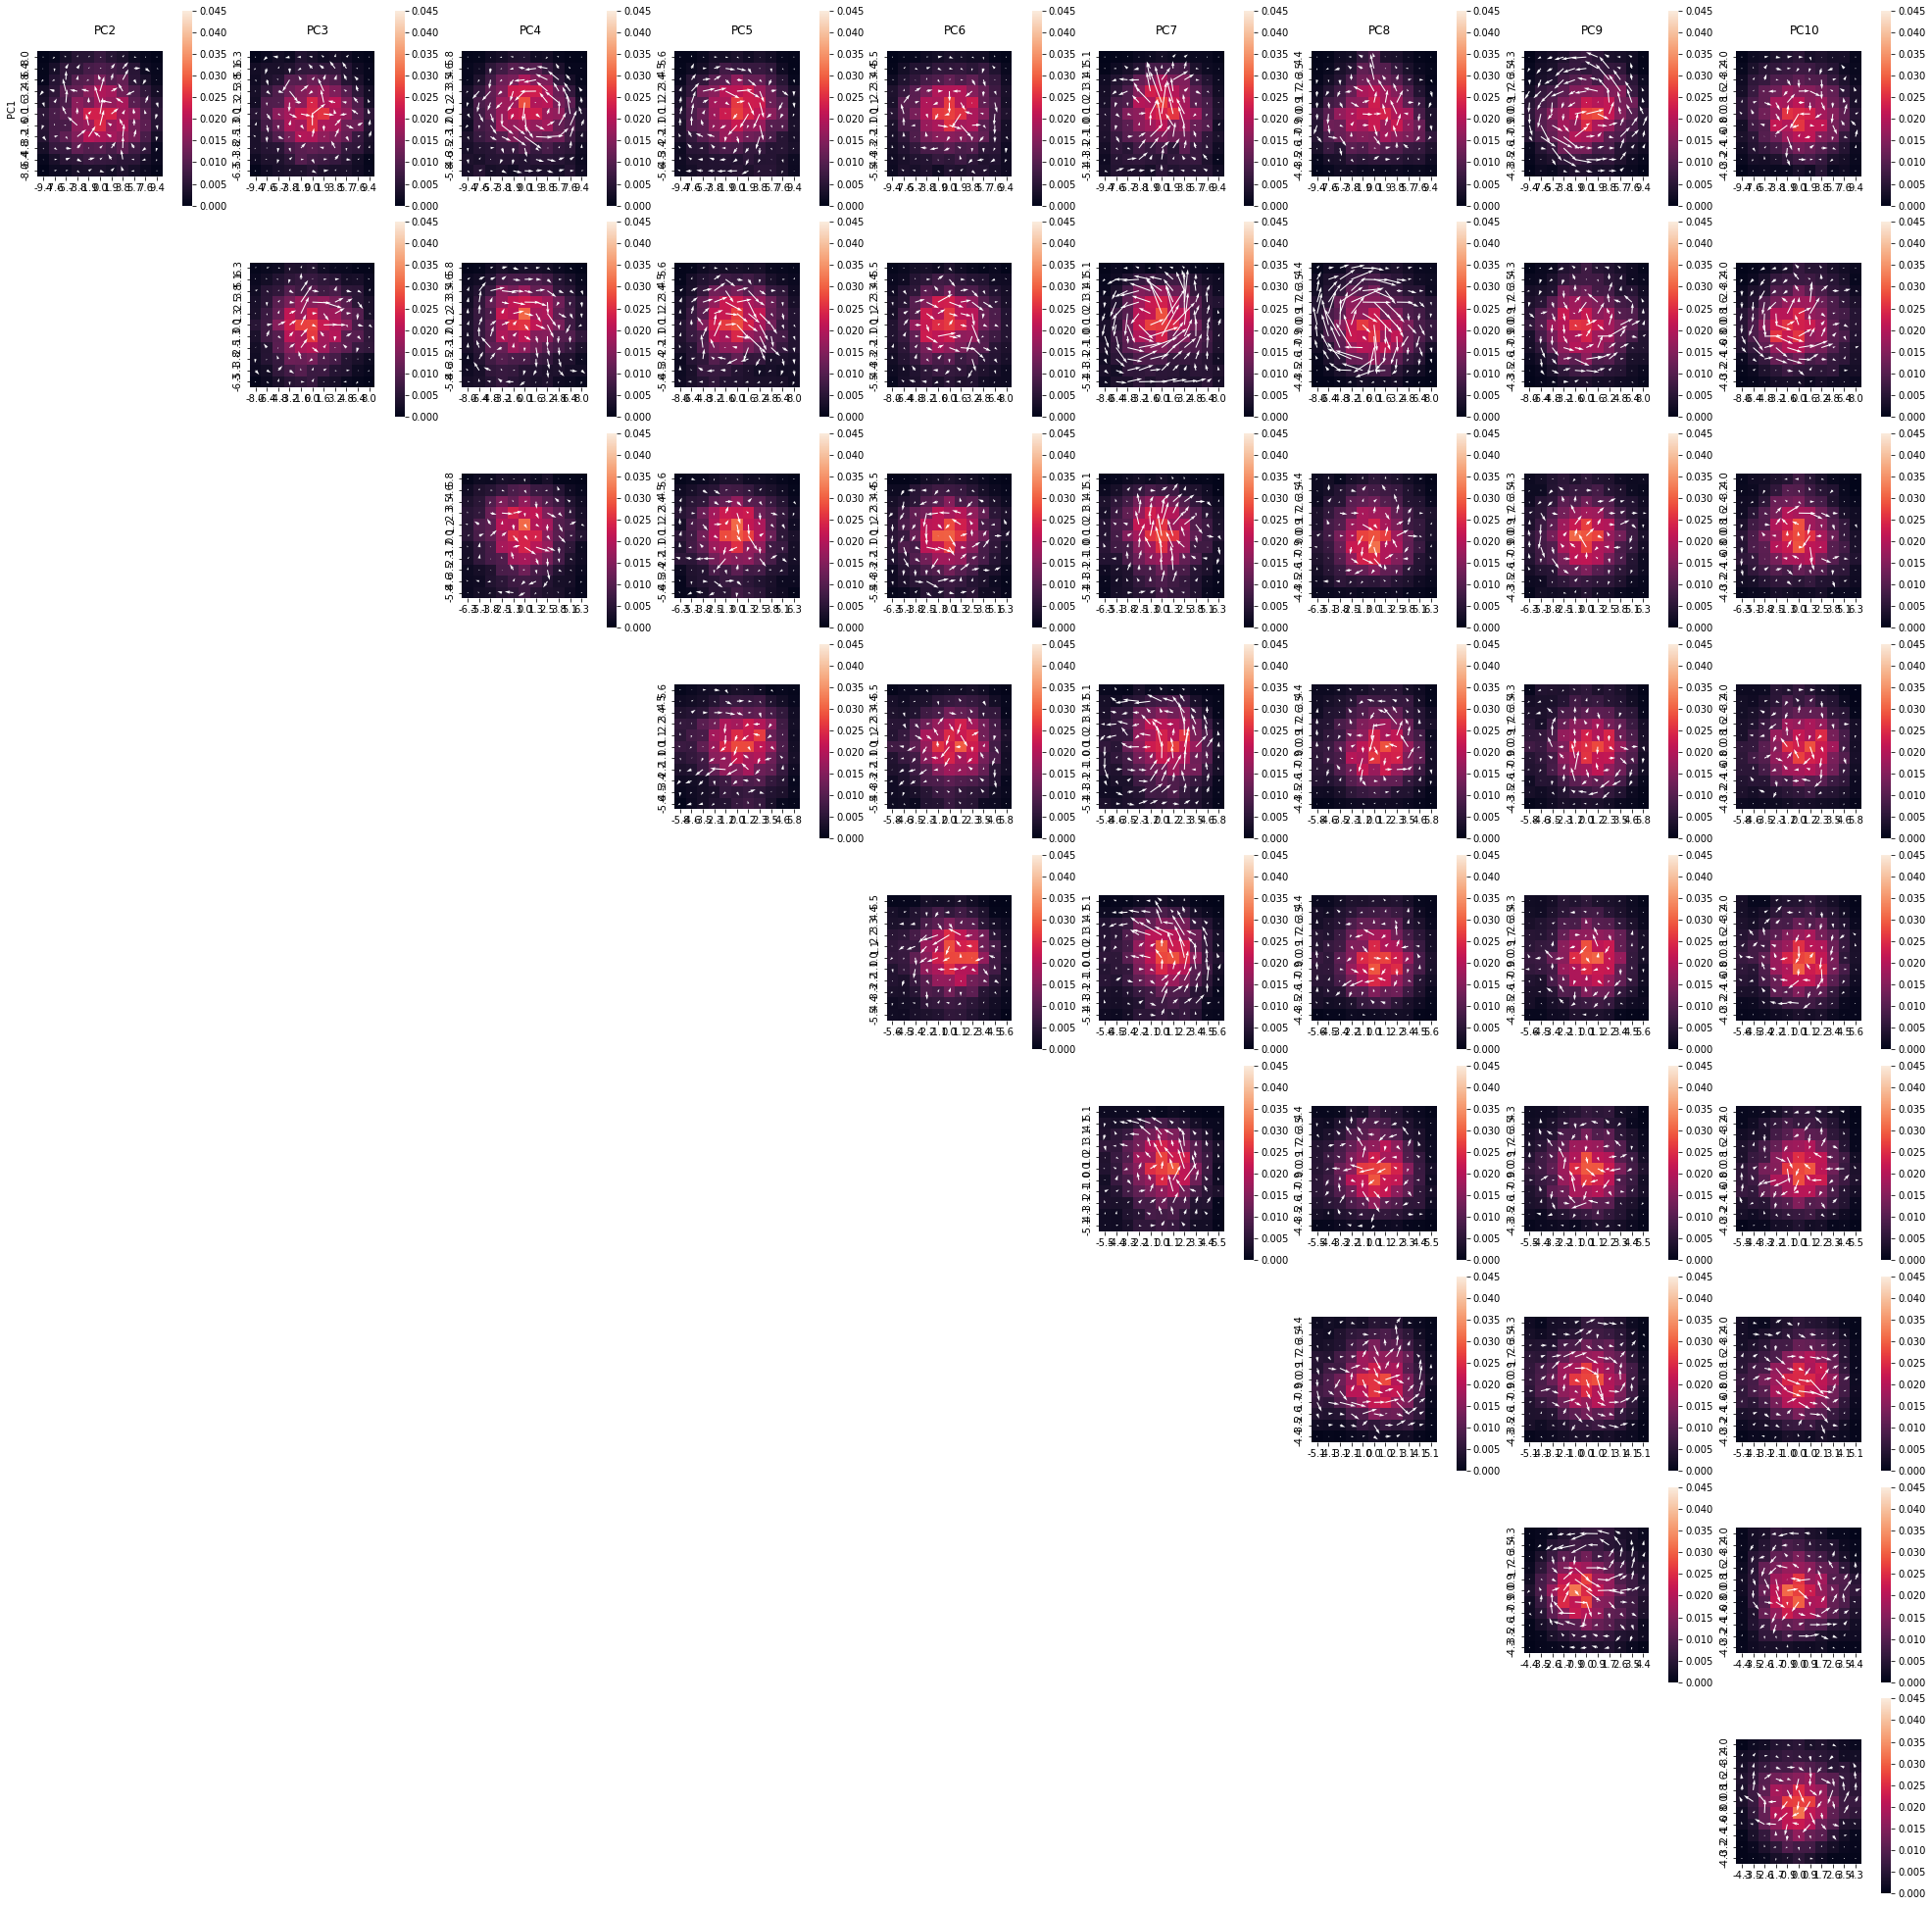

In [12]:
########### ONE BIG DIAGONAL GRAPH OF ALL PC CGPS's ##############

from CustomFunctions.DetailedBalance import get_transition_counts, interpolate_2dtrajectory
import itertools
from matplotlib.patches import Ellipse, Rectangle
from CustomFunctions.DetailedBalance import contour_coords

binlist = [i for i in TotalFrame.columns.to_list() if 'bin' in i]
fig, axes = plt.subplots(len(binlist),len(binlist), figsize = (30,30))
nn = 0
for a in binlist[::-1]:
    for b in binlist[::-1]:
        bin1 = a.split('bin')[0]
        bin2 = b.split('bin')[0]
        
        ax = axes.flatten()[::-1][nn]
        ############## get the counts of cells leaving 


        if os.path.exists(savedir+ 'All_CGPS/' +f'{bin1}-{bin2}_binned_transition_rates_separated.csv'):
            transdf_sep = pd.read_csv(savedir+ 'All_CGPS/' +f'interpolated_{bin1}-{bin2}_transitions_separated.csv', index_col=0)
            trans_rate_df_sep = pd.read_csv(savedir+ 'All_CGPS/' +f'{bin1}-{bin2}_binned_transition_rates_separated.csv', index_col=0)
            print(f'Opened {bin1}-{bin2} transition rate files')
            
            ########### PDFs AND PROBABILITY FLUX OF THE SEPARATED MIGRATION MODES #############
            # inverse scale for arrows
            scale = 0.0005

            
#             #single colorbar axis
#             cbar_ax = fig.add_axes([.98, .2, .015, .5])

            ################ heatmap of probability density #############
            ttot = transdf_sep.time_elapsed.sum()
            #make numpy array with heatmap data
            bighm = np.zeros((nbins,nbins))
            #get total time observed in the system

            for x in range(nbins):
                for y in range(nbins):
                    current =  transdf_sep[(transdf_sep['from_x'] == x+1) & (transdf_sep['from_y'] == y+1)]
                    if current.empty:
                        bighm[y,x] = 0
                    else:
                        bighm[y,x] = current.time_elapsed.sum()/ttot
            #plot heatmap with seaborn
            sns.heatmap(
                bighm,
                vmin=0, vmax=0.045, #center=0,
                cmap='rocket',
                square=True,
                xticklabels = True,
                yticklabels = True,
                ax = ax,
#                 cbar=i==0,
#                 cbar_ax = None if i else cbar_ax,
        #         cbar_kws=cbar_kws
            )

            ######################### vector map of probability flux ################
            for x in range(1,nbins+1):
                for y in range(1,nbins+1):
                    current = trans_rate_df_sep[(trans_rate_df_sep['x'] == x) & (trans_rate_df_sep['y'] == y)]
                    xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
                    ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
                    ax.quiver(x-0.5,
                               y-0.5, 
                               xcurrent,
                               ycurrent,
                              angles = 'xy',
                              scale_units = 'xy',
                              scale = scale,
        #                       width = 0.012,
        #                       minlength = 0.8,
                              color = 'white')




            # axis label stuff

            ax.set_xticks(np.arange(0.5,nbins+0.5),[round(x,1) for x in centers[bin1].to_list()])
            ax.set_xticklabels(ax.get_xticklabels())#, fontsize = 22)
            ax.set_yticks(np.arange(0.5,nbins+0.5),[round(x,1) for x in centers[bin2].to_list()])
            ax.set_yticklabels(ax.get_yticklabels())#, fontsize = 22)
            ax.set_xlim(0,nbins+1)
            ax.set_ylim(0,nbins+1)
            


            if a == binlist[0]:
                ax.set_title(bin2)#, fontsize = 45)
            if b == binlist[1]:
                ax.set_ylabel(bin1)#, fontsize = 45)
            
            nn=nn+1
        else:
            print('remove this plot')
            ax.remove()
            nn=nn+1
            
            
            
plt.tight_layout() 
plt.savefig(specdir + f'all cgps flux and pdf diagonal.png', bbox_inches='tight')

In [26]:
bin1, bin2

('PC1', 'PC2')

In [6]:
########### ALL METRIC CGPS's ###################

from CustomFunctions.DetailedBalance import get_transition_counts, interpolate_2dtrajectory
from CustomFunctions import shapePCAtools
import itertools


metriclist = ['Cell_Volume','Cell_SurfaceArea', 'Cell_Elongation', 'Cell_UpDownAngle', 'Cell_LeftRightAngle',
           'Volume_Front_Ratio', 'Volume_Right_Ratio', 'Volume_Top_Ratio']
for a in metriclist:
    for b in metriclist:
        bin1 = a + '_bins'
        bin2 = b + '_bins'
        
        centers = []
        for q in [a, b]:
            df_digit, bin_indexes, (bin_centers, pc_std) = shapePCAtools.digitize_shape_mode(
                df = TotalFrame,
                feature = q,
                nbins = nbins,
                filter_based_on = metriclist,
                filter_extremes_pct = 0,
                save = None,
                return_freqs_per_structs = False,
            )
            #put bin_indexes into a larger list that I can later iterate through
            TotalFrame[q+'_bins'] = df_digit.bin
            #get bin centers for each PC
            centers.append(pd.Series(bin_centers*pc_std, name=q))
        centers = pd.DataFrame(centers).T

        if a == b:
            continue
        
        elif (os.path.exists(savedir+f'interpolated_{a}-{b}_transitions_separated.csv')) & (os.path.exists(savedir+f'interpolated_{a}-{b}_transition_pairs_separated.csv')):
        
            transdf_sep = pd.read_csv(savedir+f'interpolated_{a}-{b}_transitions_separated.csv', index_col=0)
            transpairsdf_sep = pd.read_csv(savedir+f'interpolated_{a}-{b}_transition_pairs_separated.csv', index_col=0)
            print(f'Opened {a}-{b} transition files')
            #ensure that DMSO is the first in order
            transdf_sep['Treatment'] = pd.Categorical(transdf_sep.Treatment, categories=['Random','Pre-Galvanotaxis','Galvanotaxis'], ordered=True)
            transdf_sep = transdf_sep.sort_values(by='Treatment')
            transpairsdf_sep['Treatment'] = pd.Categorical(transpairsdf_sep.Treatment, categories=['Random','Pre-Galvanotaxis','Galvanotaxis'], ordered=True)
            transpairsdf_sep = transpairsdf_sep.sort_values(by='Treatment')
            
        elif (os.path.exists(savedir+f'interpolated_{b}-{a}_transitions_separated.csv')) & (os.path.exists(savedir+f'interpolated_{b}-{a}_transition_pairs_separated.csv')):
            print('Already made this plot')
            continue
            
        else:
            if __name__ ==  '__main__':
                migresults = []
                for m, Mig in TotalFrame.groupby('Treatment'):
                    results = []
                    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count()-1)
                    for i, cells in Mig.groupby('CellID'):
                        cells = cells.sort_values('frame').reset_index(drop = True)
                        runs = list()
                        #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
                        for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
                            currentrun = list(map(itemgetter(1), g))
                            list.append(runs, currentrun)

                        for r in runs:
                            r = np.array(r, dtype=int)
                            #skip runs less than 3 frames long
                            if len(r)<2:
                                pass
                            else:
                                cell = cells.iloc[[cells[cells.frame==y].index[0] for y in r]]

                                pool.apply_async(interpolate_2dtrajectory, args = (
                                    time_interval,
                                    cell.CellID.iloc[0],
                                    cell.frame.to_list(),
                                    cell[[bin1,bin2]].to_numpy(),
                                    ),
                                    callback = collect_results)
                    pool.close()
                    pool.join()


                    transdf_sep = pd.DataFrame(sum([r[0] for r in results],[]))
                    transdf_sep = transdf_sep.sort_values(by = ['CellID','frame']).reset_index(drop=True)
                    transpairsdf_sep = pd.DataFrame(sum([r[1] for r in results],[]))
                    transdf_sep['Treatment'] = pd.Categorical([m]*len(transdf_sep), categories=['Random','Pre-Galvanotaxis','Galvanotaxis'], ordered=True)
                    transpairsdf_sep['Treatment'] = pd.Categorical([m]*len(transpairsdf_sep), categories=['Random','Pre-Galvanotaxis','Galvanotaxis'], ordered=True)
                    migresults.append([transdf_sep,transpairsdf_sep])

            transdf_sep = pd.concat([mi[0] for mi in migresults])
            transpairsdf_sep = pd.concat([mi[1] for mi in migresults])
            transdf_sep.to_csv(savedir+f'interpolated_{a}-{b}_transitions_separated.csv')
            transpairsdf_sep.to_csv(savedir+f'interpolated_{a}-{b}_transition_pairs_separated.csv')
            del migresults
            print(f'Finished interpolating trajectories for {a}-{b}')
            
            
        ############## get the counts of cells leaving 


        if os.path.exists(savedir+f'{a}-{b}_binned_transition_rates_separated.csv'):
            trans_rate_df_sep = pd.read_csv(savedir+f'{a}-{b}_binned_transition_rates_separated.csv', index_col=0)
            print(f'Opened {a}-{b} transition rate files')
            #ensure that DMSO is the first in order
            trans_rate_df_sep['Treatment'] = pd.Categorical(trans_rate_df_sep.Treatment, categories=['Random','Pre-Galvanotaxis','Galvanotaxis'], ordered=True)
            trans_rate_df_sep = trans_rate_df_sep.sort_values(by='Treatment')
            
        elif os.path.exists(savedir+f'{b}-{a}_binned_transition_rates_separated.csv'):
            print('Already made this plot')
            continue
            
        else:
            trresults = []
            if __name__ ==  '__main__':
                for m, mig in transdf_sep.groupby('Treatment'):
                    ttot = mig.time_elapsed.sum()
                    print(ttot)
                    pool = multiprocessing.Pool(processes=60)
                    results = []
                    for x in range(nbins):
                        for y in range(nbins):
                            fromm = mig[(mig['from_x'] == x+1) & (mig['from_y'] == y+1)].reset_index(drop=True).to_dict()
                            to = mig[(mig['to_x'] == x+1) & (mig['to_y'] == y+1)].reset_index(drop=True).to_dict()
                            pool.apply_async(get_transition_counts, args = (
                                x+1,
                                y+1,
                                fromm,
                                to,
                                ttot,
                                ),
                                callback = collect_results)
                    pool.close()
                    pool.join()

                    trans_rate_df_sep = pd.DataFrame(results)
                    trans_rate_df_sep['Treatment'] = pd.Categorical([m]*len(trans_rate_df_sep), categories=['Random','Pre-Galvanotaxis','Galvanotaxis'], ordered=True)
                    trans_rate_df_sep = trans_rate_df_sep.sort_values(by = ['x','y']).reset_index(drop=True)
                    trresults.append(trans_rate_df_sep)

            trans_rate_df_sep = pd.concat(trresults)
            trans_rate_df_sep.to_csv(savedir+f'{a}-{b}_binned_transition_rates_separated.csv')
            del trresults

            print(f'Finished finding transition rates for {a}-{b}')

            
            
        ########### PDFs AND PROBABILITY FLUX OF THE SEPARATED MIGRATION MODES #############
        from matplotlib.patches import Ellipse, Rectangle
        from CustomFunctions.DetailedBalance import contour_coords
        # inverse scale for arrows
        scale = 0.0002


        fig, graphaxes = plt.subplots(1,3,figsize=(7.5+(10*(len(trans_rate_df_sep.Treatment.unique())-1)),10))
        #single colorbar axis
        cbar_ax = fig.add_axes([.98, .2, .015, .5])

        for i, ax in enumerate(graphaxes):
            ################ heatmap of probability density #############
            mm = transdf_sep.Treatment.unique()[i]
            mdf = transdf_sep[transdf_sep.Treatment==mm]
            ttot = mdf.time_elapsed.sum()
            #make numpy array with heatmap data
            bighm = np.zeros((nbins,nbins))
            #get total time observed in the system

            for x in range(nbins):
                for y in range(nbins):
                    current =  mdf[(mdf['from_x'] == x+1) & (mdf['from_y'] == y+1)]
                    if current.empty:
                        bighm[y,x] = 0
                    else:
                        bighm[y,x] = current.time_elapsed.sum()/ttot
            #plot heatmap with seaborn
            sns.heatmap(
                bighm,
                vmin=0, vmax=0.05, #center=0,
                cmap='rocket',
                square=True,
                xticklabels = True,
                yticklabels = True,
                ax = ax,
                cbar=i==0,
                cbar_ax = None if i else cbar_ax,
        #         cbar_kws=cbar_kws
            )

            ######################### vector map of probability flux ################
            mm = trans_rate_df_sep.Treatment.unique()[i]
            mdf = trans_rate_df_sep[trans_rate_df_sep.Treatment==mm]

            for x in range(1,nbins+1):
                for y in range(1,nbins+1):
                    current = mdf[(mdf['x'] == x) & (mdf['y'] == y)]
                    xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
                    ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
                    ax.quiver(x-0.5,
                               y-0.5, 
                               xcurrent,
                               ycurrent,
                              angles = 'xy',
                              scale_units = 'xy',
                              scale = scale,
        #                       width = 0.012,
        #                       minlength = 0.8,
                              color = 'white')




            # axis label stuff
            ax.set_xlabel(a, fontsize = 45)
            ax.set_xticks(np.arange(0.5,nbins+0.5),[round(x,1) for x in centers[a].to_list()])
            ax.set_xticklabels(ax.get_xticklabels(), fontsize = 22)
            ax.set_yticks(np.arange(0.5,nbins+0.5),[round(x,1) for x in centers[b].to_list()])
            ax.set_yticklabels(ax.get_yticklabels(), fontsize = 22)
            ax.set_xlim(0,nbins+1)
            ax.set_ylim(0,nbins+1)
            ax.set_title(mm, fontsize = 45)


        # adjust colorbar tick label size
        cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
        #set axis title
        graphaxes[0].set_ylabel(b, fontsize = 45)



        ########## add scale for the vectors ##########
        #legend background
        lxp = 0.125
        lyp = 0.125
        rect = Rectangle((lxp, lyp), 1.8, 1.8, linewidth=1, edgecolor='black', facecolor='#80858a')
        graphaxes[0].add_patch(rect)
        rect.set_zorder(4 * 5)
        #x-axis legend arrow
        graphaxes[0].quiver(lxp+0.5,lyp+0.5,1*scale,0,angles = 'xy',scale_units = 'xy',scale = scale,color = "white",zorder = 4 * 5)
        #x-axis legend text
        xsc = f'{(np.diff(centers[a]).mean()/time_interval)*scale:.1e}'
        xsc = xsc.split('-')[0] + str(int(xsc.split('e')[1]))
        graphaxes[0].text(lxp+0.25,lyp+0.05,xsc+' $s^{-1}$', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)
        #y-axis legend arrow
        graphaxes[0].quiver(lxp+0.5,lyp+0.5,0,1*scale,angles = 'xy',scale_units = 'xy',scale = scale,color = 'white',zorder = 4 * 5)
        #y-axis legend text
        ysc = f'{(np.diff(centers[b]).mean()/time_interval)*scale:.1e}'
        ysc = ysc.split('-')[0] + str(int(ysc.split('e')[1]))
        graphaxes[0].text(lxp+0.05,lyp+0.3,ysc+' $s^{-1}$', rotation = 'vertical', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)



        plt.tight_layout()
        plt.savefig(savedir + f'{bin1}-{bin2} probability flux and pdf separated.png', bbox_inches='tight')
        plt.close()
        print(f'Saved {bin1}-{bin2} plot')

Finished interpolating trajectories for Cell_Volume-Cell_SurfaceArea
69423.71235948785
9578.435879733293
64372.28280905215
Finished finding transition rates for Cell_Volume-Cell_SurfaceArea


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:215: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:217: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:253: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Saved Cell_Volume_bins-Cell_SurfaceArea_bins plot
Finished interpolating trajectories for Cell_Volume-Cell_Elongation
70667.84575426238
9883.437181028145
65805.07569279756
Finished finding transition rates for Cell_Volume-Cell_Elongation
Saved Cell_Volume_bins-Cell_Elongation_bins plot
Finished interpolating trajectories for Cell_Volume-Cell_UpDownAngle
71255.57616833663
9972.064206235085
66432.5375229298
Finished finding transition rates for Cell_Volume-Cell_UpDownAngle
Saved Cell_Volume_bins-Cell_UpDownAngle_bins plot
Finished interpolating trajectories for Cell_Volume-Cell_LeftRightAngle
69734.17696050346
9614.902498910506
64855.94927991344
Finished finding transition rates for Cell_Volume-Cell_LeftRightAngle
Saved Cell_Volume_bins-Cell_LeftRightAngle_bins plot
Finished interpolating trajectories for Cell_Volume-Volume_Front_Ratio
70816.76120062535
10040.244757025648
66127.24451263946
Finished finding transition rates for Cell_Volume-Volume_Front_Ratio
Saved Cell_Volume_bins-Volume_